# HIST OF EXTRACTION OF SYMMETRIES

In [ ]:
from template_csp import managetemp_withdict as mte
import numpy as np  
import json
import matplotlib.pyplot as plt

test_elements = ['Be', 'B', 'N', 'Mg', 'O', 'Li', 'C', 'Na', 'Si', 'S', 'Cl', 'F', 'P', 'H', 'Al']

hyperparameters = { 
    "weight_occurrence" : 1,
    "weight_sg" : 0.001,
    "weight_formation_entalphy" : 1, 
    "comp" : 1,
    "lev_red" : 0.9,
    "n_pairs" : 105,
}

complist = [1,2,3,4]
tempinit = 25
tempend = 25 #compreso
mother_dir = './HvsINIT/'

for comp in complist:
    hyperparameters["comp"] = comp  
    same_struct = {}
    with open(f'./SAME_STRUCT_DICT/same_structuresA{comp}B.json') as f:
        same_struct = json.load(f)

    if comp == 1:
        hyperparameters["n_pairs"] = 105
    else:
        hyperparameters["n_pairs"] = 210

    for temp_tot in range(tempinit, tempend +1):
        average_res = 0
        for id_set in range(20):
            init_set = mte.TemplateSet(test_elements=test_elements, hyperparameters=hyperparameters, restart_file=mother_dir+f'{comp}/{temp_tot}/TemplateSet_{id_set}')
            fin_set = mte.PairSet(template_set=init_set, test_elements=test_elements, hyperparameters=hyperparameters, relaxed_pairs=mother_dir+f'{comp}/{temp_tot}/PairSet_{id_set}')
            final_set_idx = fin_set.reduced_set()
            final_set = [f'{init_set.pairs[x][0][0]}{init_set.pairs[x][0][1]}_{init_set.pairs[x][1]}' for x in final_set_idx]
            average_res += len(final_set)/20
            for temp in final_set:
                for group in same_struct.keys():
                    if temp in same_struct[group]['temp']:
                        same_struct[group]['count'] += 1
                        break
        
        x = [f'{idx}/{key.split(',')[0][1:]}' for idx, key in enumerate(same_struct.keys())]
        x = np.array(x)
        y = [same_struct[key]['count'] for key in same_struct.keys()]
        y = np.array(y)

        idx_sort_y = np.argsort(y)
        x = x[idx_sort_y][::-1]
        y = y[idx_sort_y][::-1]
        

        fig, ax1 = plt.subplots(1, 1, figsize=(14, 8))
        fig.suptitle('FINAL SET COUNT', fontsize=22, y=0.93, fontweight='bold')
        ax1.bar(x, y, color = 'crimson', edgecolor = 'black', linewidth = 2, alpha=0.7)
        ax1.vlines(average_res-1, 0, max(y)+5, colors='blue', linestyles='dashed', label='Average size finale set')
        ax1.set_xlabel('SG (same wyck pos)', fontsize=18)
        ax1.set_xticks(x)
        ax1.set_xticklabels([a.split('/')[1] for a in x], rotation=90)
        ax1.set_ylim(0, max(y)+5)
        ax1.set_ylabel('Count', fontsize=18)
        ax1.legend(loc='upper right', fontsize=16)
        plt.show()
        fig.savefig(f'./FIG/HIST_FINAL_A{comp}B.png')



    

# GENERATE NEW DATA FROM TEMPLATE SET

### SIZE FINAL SET

In [ ]:
from template_csp import managetemp as mte 
import numpy as np
import json
from tqdm import tqdm

test_elements = ['Be', 'B', 'N', 'Mg', 'O', 'Li', 'C', 'Na', 'Si', 'S', 'Cl', 'F', 'P', 'H', 'Al']

hyperparameters = { 
    "weight_occurrence" : 1,
    "weight_sg" : 0.001,
    "weight_formation_entalphy" : 1, 
    "comp" : 1,
    "lev_red" : 0.9,
    "n_pairs" : 105,

    "n_final_templates" : 1
}

data = {}

complist = [1,2,3,4,6]
n_set = 20
temp_list = [[20,30,40,50],[30, 45, 60, 75], [30, 40, 50, 60], [30, 40, 50, 60], [10,20,30,35]]

mother_dir = './HvsINIT/'

for comp, temp_steps in tqdm(zip(complist, temp_list)):
    hyperparameters["comp"] = comp
    data[comp] = {}

    if comp == 1:
        hyperparameters["n_pairs"] = 105
    else:
        hyperparameters["n_pairs"] = 210

    for temp_init in temp_steps:
        data[comp][temp_init] = {'errors_before': {}, 'errors_after': {}}

        errors_before = np.zeros((2, temp_init))
        errors_after = np.zeros((2, temp_init))

        for size_final in range(1, temp_init + 1):
            hyperparameters["n_final_templates"] = size_final

            er_aft = []
            er_bef = []

            for id_set in range(n_set):
                init_set = mte.InitialSet(test_elements=test_elements, hyperparameters=hyperparameters, restart_file=mother_dir+f'{comp}/{temp_init}/InitialSet_{id_set}')
                fin_set = mte.generate_final_set(init_set=init_set, hyperparameters=hyperparameters, test_elements=test_elements)

                er_bef.append(init_set.difference_from_uspex())
                er_aft.append(fin_set.difference_from_uspex())
            
            errors_before[0][size_final-1] = np.mean(er_bef)
            errors_before[1][size_final-1] = np.std(er_bef)
            errors_after[0][size_final-1] = np.mean(er_aft)
            errors_after[1][size_final-1] = np.std(er_aft)
        
        data[comp][temp_init]['errors_before']['mean'] = errors_before[0].tolist()
        data[comp][temp_init]['errors_before']['std'] = errors_before[1].tolist()
        data[comp][temp_init]['errors_after']['mean'] = errors_after[0].tolist()
        data[comp][temp_init]['errors_after']['std'] = errors_after[1].tolist()
    
    with open('./Errors1.json', 'w') as f:
        json.dump(data, f, indent=4)
                

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import json

from pyfonts import load_font
from matplotlib.font_manager import FontProperties

# load font
helvetica_bold = load_font("/home/seraf/Downloads/helvetica-255/Helvetica-Bold.ttf")
helv_bold_prop = FontProperties(fname="/home/seraf/Downloads/helvetica-255/Helvetica-Bold.ttf", size=35)

helvetica_strange = load_font("/home/seraf/Downloads/helvetica-255/helvetica-light-587ebe5a59211.ttf")
helv_strange_prop = FontProperties(fname="/home/seraf/Downloads/helvetica-255/helvetica-light-587ebe5a59211.ttf", size=20)


with open('DATA_DICT/Errors1.json') as f:
    data = json.load(f)

for comp in data.keys():
    if comp != '3':
        continue
    fig, ax = plt.subplots(1, 1, figsize=(15, 10))
    title = r'Prediction with SET2 in A$_3$B'
    ax.set_title(title, fontproperties=helv_bold_prop, pad=10)

    colorlist = ['red', 'blue', 'green', 'orange', 'purple', 'brown']

    for idx, temp_init in enumerate(data[comp].keys()):
        x = np.arange(1, int(temp_init)+1)
        y_bef = data[comp][temp_init]['errors_before']['mean'][0]
        y_aft = data[comp][temp_init]['errors_after']['mean']
    
        ax.hlines(y_bef*1000, 0, 70, color=colorlist[idx], lw=1, linestyle='--')
        ax.plot(x, np.array(y_aft)*1000, color=colorlist[idx], lw=1, marker='o', markersize=10, markeredgecolor='white')
        ax.add_artist(plt.Line2D((0, 0), (0, 0), color=colorlist[idx], linestyle='solid', lw=4, label=f'{temp_init}'))
    
    ax.add_artist(plt.Line2D((0, 0), (0, 0),marker='o', markersize=10, color='black', linestyle='solid', lw=4, label='SET2'))
    ax.add_artist(plt.Line2D((0, 0), (0, 0), color='black', linestyle='dashed', lw=4, label='SET1'))

    ax.set_xlabel('SIZE SET2', fontsize=25, font=helvetica_strange, labelpad=10)
    ax.set_xticks(np.arange(0, 101, 5))
    ax.set_xticklabels([f'{x:.0f}' for x in np.arange(0, 101, 5)])

    max_y = 151
    min_y = 0

    ax.set_ylabel(r'$\Delta$H $_{USPEX-TEMP}$ [meV/atom]', fontsize=25, font=helvetica_strange, labelpad=10)
    ax.yaxis.set_major_locator(plt.MultipleLocator(20))

    ax.tick_params(size=7, labelsize=15)
    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_fontproperties(helv_strange_prop)

    ax.legend(loc='upper right', prop=helv_strange_prop, ncol=1, handlelength=1.5)
    ax.set_xlim(1,70)
    ax.set_ylim(min_y,max_y)
    ax.grid(ls = '--', lw = 0.5)
    plt.show()
    fig.savefig(f'./FIG/Articolo/SET2_DH_NewLev.png')

### VALIDATION PAIRS CONTINUUM

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import json

from pyfonts import load_font
from matplotlib.font_manager import FontProperties

# load font
helvetica_bold = load_font("/home/seraf/Downloads/helvetica-255/Helvetica-Bold.ttf")
helv_bold_prop = FontProperties(fname="/home/seraf/Downloads/helvetica-255/Helvetica-Bold.ttf", size=35)

helvetica_strange = load_font("/home/seraf/Downloads/helvetica-255/helvetica-light-587ebe5a59211.ttf")
helv_strange_prop = FontProperties(fname="/home/seraf/Downloads/helvetica-255/helvetica-light-587ebe5a59211.ttf", size=20)

list_files = ['Perm', 'Normal', 'NoWeight', 'Normal_RenormalizedSub']

name_file = 'DATA_DICT/NumberOfPairs/NumberOfPairs_Perm.json'
with open(name_file) as f:
    data_names = json.load(f)


colorlist = ['red', 'blue', 'green', 'orange', 'purple', 'brown', 'black']
# with open('DATA_DICT/UsedCritPairs.json') as f:
#     data_crit = json.load(f)

temp_list = [[20,30,40], [40,50,60], [30,40,50], [30,40,50], [20,30,40]] # template iniziali per ogni comp
temp_final = [10, 20, 15, 15, 10]

for comp in data_names.keys():

    tot_pairs = 105 if int(comp) == 1 else 210

    fig, ax = plt.subplots(1, 1, figsize=(15, 10))
    title = f'Different Number of Trial Pairs with A{comp}B'
    ax.set_title(title, fontproperties=helv_bold_prop, pad=10)

    for temp_init in data_names[comp]['ErrBef'].keys():

        for idx, name_file in enumerate(list_files):

            with open(f'./DATA_DICT/NumberOfPairs/NumberOfPairs_{name_file}.json') as f:
                data = json.load(f)
            x = []
        
            ## Error before

            # err_bef = data[comp]['ErrBef'][str(temp_init)]
            # ax.hlines(err_bef*1000, 1, tot_pairs, colors='black', linestyles='solid',color = colorlist[idx], lw=1)

            y_aft = []
            std_aft = []

            for npair in data[comp]['ErrAft'][str(temp_init)].keys():
                x.append(int(npair))
                y_aft.append(data[comp]['ErrAft'][str(temp_init)][npair])

            ## STD
            #     std_aft.append(data[comp]['StdAft'][str(temp_init)][npair])
            # ax.errorbar(x, np.array(y_aft)*1000, yerr=np.array(std_aft)*1000, color=colorlist[idx], lw=1, linestyle='dashed', marker='o', markersize=10, markeredgecolor = 'white')

            ax.plot(x, np.array(y_aft)*1000, color=colorlist[idx], lw=1, linestyle='dashed', marker='o', markersize=10, markeredgecolor = 'white')
            ## Error after with all pairs

            # y_full_pairs = y_aft[-1]
            # ax.hlines(y_full_pairs*1000, 1, tot_pairs, color = colorlist[idx], linestyles='dashed', lw=1)

            ax.add_artist(plt.Line2D((0, 0), (0, 0), color=colorlist[idx], linestyle='solid', lw=4, label=f'{name_file}'))
    
    ## weight of first component
    # ax2 = ax.twinx()

    # y_w = []
    # for npair in data[comp]['ErrAft'][str(temp_init)].keys():
    #     summ = 0
    #     for i in range(int(npair)):
    #         summ += (1-float(i)/float(npair))
    #     y_w.append(1./summ)
    # ax.vlines(x[np.argmin(y_aft)],0,160, color = 'red', lw = 1, ls = '--')

    # ax2.plot(x, np.array(y_w), lw=3, color= 'purple')
    # ax2.hlines(y_w[np.argmin(y_aft)], x[np.argmin(y_aft)],tot_pairs, color = 'black', lw = 2, ls='--')
    
    # ax2.set_ylabel('Weight of 1st component', fontsize=25, font=helvetica_strange, labelpad=10)
    # ax2.tick_params(size=7, labelsize=15)
    # for label in ax2.get_yticklabels():
    #     label.set_fontproperties(helv_strange_prop)
    # ax2.set_ylim(-0.01, 0.3)
    # ax.add_artist(plt.Line2D((0, 0), (0, 0), color='purple', linestyle='solid', lw=4, label='Weight of 1st comp'))


    ## Number of critical pairs
    # ax2 = ax.twinx()

    # y_crit = []
    # for npair in data_crit[comp][str(temp_init)].keys():
    #     y_crit.append(data_crit[comp][str(temp_init)][npair])
    # ax2.plot(x, np.array(y_crit), color=colorlist2[idx], lw=1, linestyle='dashed', marker='o', markersize=10, markeredgecolor = 'white')

    # ax2.set_ylabel('Number of Critical Pairs', fontsize=25, font=helvetica_strange, labelpad=10)
    # ax2.tick_params(size=7, labelsize=15)
    # for label in ax2.get_yticklabels():
    #     label.set_fontproperties(helv_strange_prop)
    # ax.add_artist(plt.Line2D((0, 0), (0, 0), color='purple', linestyle='solid', lw=4, label='Critical Pairs'))

    step_x = 5 if tot_pairs == 105 else 10
    ax.set_xlabel(r'N$_T$', fontsize=25, font=helvetica_strange, labelpad=10)
    ax.set_xticks(np.arange(0, tot_pairs, step_x))
    ax.set_xticklabels([f'{x:.0f}' for x in np.arange(0, tot_pairs, step_x)])

    ax.set_ylabel(r'$\Delta$H$_{USPEX-TEMPLATE}$ [meV/at]', fontsize=25, font=helvetica_strange, labelpad=10)
    ax.yaxis.set_major_locator(plt.MultipleLocator(10))
    ax.tick_params(size=7, labelsize=15)
    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_fontproperties(helv_strange_prop)

    ax.legend(loc='upper right', prop=helv_strange_prop, ncol=2, handlelength=1.5)
    ax.set_xlim(0, x[-1]+ 1)
    ax.set_ylim(70, 150)
    ax.grid(ls = '--', lw = 0.5)
    plt.show()

    # fig.savefig(f'./FIG/{comp}/{comp}_{name_file.split('_')[-1].split('.')[0]}.png')
    # fig.savefig(f'./FIG/{comp}/NumberOfPairs_allDistances.png')

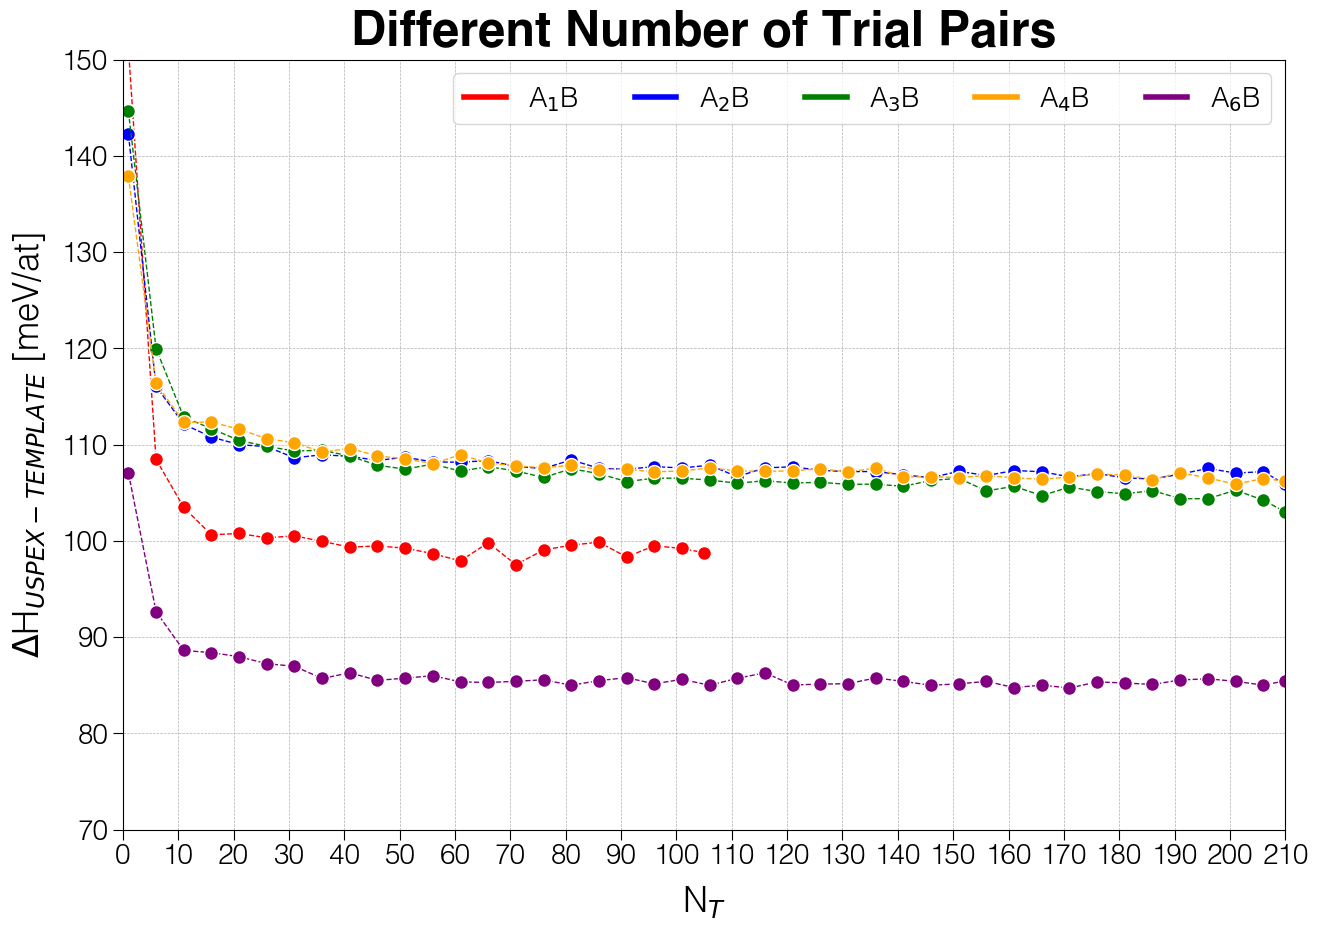

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import json

from pyfonts import load_font
from matplotlib.font_manager import FontProperties

# load font
helvetica_bold = load_font("/home/seraf/Downloads/helvetica-255/Helvetica-Bold.ttf")
helv_bold_prop = FontProperties(fname="/home/seraf/Downloads/helvetica-255/Helvetica-Bold.ttf", size=35)

helvetica_strange = load_font("/home/seraf/Downloads/helvetica-255/helvetica-light-587ebe5a59211.ttf")
helv_strange_prop = FontProperties(fname="/home/seraf/Downloads/helvetica-255/helvetica-light-587ebe5a59211.ttf", size=20)


name_file = 'DATA_DICT/NumberOfPairs/NumberOfPairs_Normal_RenormalizedSub.json'
with open(name_file) as f:
    data = json.load(f)

colorlist = ['red', 'blue', 'green', 'orange', 'purple', 'brown', 'black']

fig, ax = plt.subplots(1, 1, figsize=(15, 10))
title = f'Different Number of Trial Pairs'
ax.set_title(title, fontproperties=helv_bold_prop, pad=10)

for idx, comp in enumerate(data.keys()):




    for temp_init in data[comp]['ErrBef'].keys():

        x = []
    

        y_aft = []
        std_aft = []

        for npair in data[comp]['ErrAft'][str(temp_init)].keys():
            x.append(int(npair))
            y_aft.append(data[comp]['ErrAft'][str(temp_init)][npair])


        ax.plot(x, np.array(y_aft)*1000, color=colorlist[idx], lw=1, linestyle='dashed', marker='o', markersize=10, markeredgecolor = 'white')

        ax.add_artist(plt.Line2D((0, 0), (0, 0), color=colorlist[idx], linestyle='solid', lw=4, label=f'A$_{comp}$B'))

tot_pairs = 210
step_x =  10
ax.set_xlabel(r'N$_T$', fontsize=25, font=helvetica_strange, labelpad=10)
ax.set_xticks(np.arange(0, tot_pairs+1, step_x))
ax.set_xticklabels([f'{x:.0f}' for x in np.arange(0, tot_pairs+1, step_x)])


ax.set_ylabel(r'$\Delta$H$_{USPEX-TEMPLATE}$ [meV/at]', fontsize=25, font=helvetica_strange, labelpad=10)
ax.yaxis.set_major_locator(plt.MultipleLocator(10))
ax.tick_params(size=7, labelsize=15)
for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_fontproperties(helv_strange_prop)

ax.legend(loc='upper right', prop=helv_strange_prop, ncol=5, handlelength=1.5)
ax.set_xlim(0, x[-1])
ax.set_ylim(70, 150)
ax.grid(ls = '--', lw = 0.5)
plt.show()

fig.savefig(f'./FIG/Articolo/NT.png')

# POSSIBLE EXPLANATIONS

In [ ]:
import json
import numpy as np
import re

data_dict = {}

with open('ENTHALPY/A1B.json', 'r') as f:
    data_dict = json.load(f)

one_el_dict = {}

with open('ENTHALPY/OneEl.json', 'r') as f:
    one_el_dict = json.load(f)


final_data = {}

for pair in data_dict.keys():
    A = re.findall(r'[A-Z][a-z]*', pair)[0]
    B = re.findall(r'[A-Z][a-z]*', pair)[1]

    final_data[pair] = {}
    ent_vec = np.array([i - (one_el_dict[A] + one_el_dict[B])/2 for _, i in data_dict[pair].items()])
    temp_vec = np.array([i for i, _ in data_dict[pair].items()])

    sorted_idx = np.argsort(ent_vec)
    final_data[pair]['Sorted Enthalpies'] = ent_vec[sorted_idx].tolist()
    final_data[pair]['Sorted Templates'] = temp_vec[sorted_idx].tolist()

with open('A1B_SortedData.json', 'w') as f:
    json.dump(final_data, f, indent=4)


In [ ]:
import  json
import numpy as np
import re

with open('ENTHALPY/A1B.json', 'r') as f:
    data_dict = json.load(f)

with open('ENTHALPY/OneEl.json', 'r') as f:
    one_el_dict = json.load(f)

temp_list = list(data_dict['BBe'].keys())
temp_dict = {}

for temp in temp_list:
    temp_dict[temp] = {'Pairs': [], 'Enthalpy': []}
    pair_vec = []
    ent_vec = []
    
    for pair in data_dict.keys():
        A = re.findall(r'[A-Z][a-z]*', pair)[0]
        B = re.findall(r'[A-Z][a-z]*', pair)[1]
        if temp in data_dict[pair].keys():
            enthalpy = data_dict[pair][temp] - (one_el_dict[A] + one_el_dict[B])/2
            pair_vec.append(pair)
            ent_vec.append(enthalpy)

    pair_vec = np.array(pair_vec)
    ent_vec = np.array(ent_vec)

    sorted_idx = np.argsort(ent_vec)
    temp_dict[temp]['Pairs'] = pair_vec[sorted_idx].tolist()
    temp_dict[temp]['Enthalpy'] = ent_vec[sorted_idx].tolist()

with open('DATA_DICT/A1B_ISTO.json', 'w') as f:
    json.dump(temp_dict, f)


In [ ]:
import json
with open('DATA_DICT/A1B_ISTO.json', 'r') as f:
    data = json.load(f)

pair_list = list(data["AlLi_187"]["Pairs"])
print(pair_list)
ist_vec = [0 for _ in range(len(pair_list))]

for temp in data.keys():
    for idx, pair in enumerate(data[temp]['Pairs']):
        if idx > 2:
            break
        ist_vec[pair_list.index(pair)] += 1

import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(18, 10))
ax.bar(pair_list, ist_vec, color='crimson', edgecolor='black', linewidth=2, alpha=0.7)
ax.set_xlabel('Pairs', fontsize=18)
ax.set_ylabel('Occurrences', fontsize=18)
ax.set_title('Times Pairs occupies First or Second', fontsize=22, fontweight='bold')
ax.set_xticklabels(pair_list, rotation=90)
ax.grid(ls='--', lw=0.5)
ax.set_xlim(-0.5, len(pair_list)-0.5)
plt.show()


